# **Dynamic Concert Ticket Price Prediction Model**

## **Project Overview**
In this project, I build a **Dynamic Ticket Price Prediction Model** using a custom dataset. The model predicts ticket prices based on key features, such as artist popularity, artist attributes, and time until the event. The ultimate goal is to enable dynamic pricing for event tickets, enhancing revenue management and customer satisfaction.

The dataset for this project are available in the repository linked below:
- [**Data Extraction Workflow**](https://github.com/RaghaviRajumohan/Rhythms-of-Data/blob/main/Dynamic_ticket_price_prediction_model/Data_extraction_and_construction.ipynb)

In [1]:
import pandas as pd 
import time  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
import ipywidgets as widgets
from IPython.display import display, HTML
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS, add_constant
from ipywidgets import Layout, widgets
import random

## 1. Data Cleaning and Preprocessing

In [2]:
data = pd.read_csv('all_venues_events.csv')
data.columns = data.columns.str.replace(' ', '_')

In [3]:
# Identify non-numeric rows in 'Total_Tickets'
non_numeric_mask = ~pd.to_numeric(data["Total_Tickets"], errors='coerce').notna()

# Convert 'Total_Tickets' to numeric, keeping non-numeric rows as NaN
data["Total_Tickets"] = pd.to_numeric(data["Total_Tickets"], errors='coerce')

# Compute the mode 'Total_Tickets' for each venue
def compute_mode(series):
    mode_values = series.mode()
    return mode_values[0] if not mode_values.empty else None

venue_mode = data.groupby("Venue_Name")["Total_Tickets"].apply(compute_mode)

# Replace NaN venue modes with the overall mode
overall_mode = data["Total_Tickets"].mode()[0]  # Mode for the entire column
venue_mode = venue_mode.fillna(overall_mode)  # Fill missing venue modes with overall mode

# Replace NaN and non-numeric rows with the venue-specific mode
data["Total_Tickets"] = data.apply(
    lambda row: venue_mode[row["Venue_Name"]] if pd.isna(row["Total_Tickets"]) else row["Total_Tickets"],
    axis=1
)

# Add a new column with the log-transformed Followers and Average Price
data['Log_Followers'] = np.log1p(data['Followers']) 
data['Avg_Ticket_Price'] = (data['Min_Ticket_Price'] + data['Max_Ticket_Price']) / 2

In [4]:
# Drop rows with null values in 'Public_Onsale_Date' and 'Days_Since_Onsale'
data = data.dropna(subset=['Public_Onsale_Date', 'Days_Since_Onsale'])
data['Years_Active'] = data['Years_Active'].fillna(0)
# Verify the result
print(data.isnull().sum()) 

Event_ID                          0
Event_Name                        0
Venue_Name                        0
Main_Artist                       0
Supporting_Artists              499
Supporting_Artist_Popularity      0
Total_Tickets                     0
Date_of_Show                      0
Min_Ticket_Price                  0
Max_Ticket_Price                  0
Spotify_Artist_Name               0
Popularity_Score                  0
Followers                         0
Genre                           154
Years_Active                      0
Public_Onsale_Date                0
Days_to_Event                     0
Days_Since_Onsale                 0
Day_of_Week                       0
Is_Weekend                        0
Venue_ID                          0
Reddit_Mentions_Today             0
Log_Followers                     0
Avg_Ticket_Price                  0
dtype: int64


## 2. Exploratory Data Analysis

In [5]:
data['Day_of_Week'] = pd.to_datetime(data['Date_of_Show']).dt.day_name()
average_prices = data.groupby('Day_of_Week')['Min_Ticket_Price'].mean()

# Sort days for better readability
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_prices = average_prices.reindex(days_order)

# Round to 2 decimal places
average_prices = average_prices.round(2)

# Display average prices with a formatted heading
heading = "\033[1;34mAverage Ticket Prices by Day of the Week\033[0m" 
print(heading)
print(average_prices.to_string())

Average Ticket Prices by Day of the Week
Day_of_Week
Monday       37.58
Tuesday      33.35
Wednesday    35.50
Thursday     34.28
Friday       35.15
Saturday     39.24
Sunday       40.62


#### 1. Box Plots

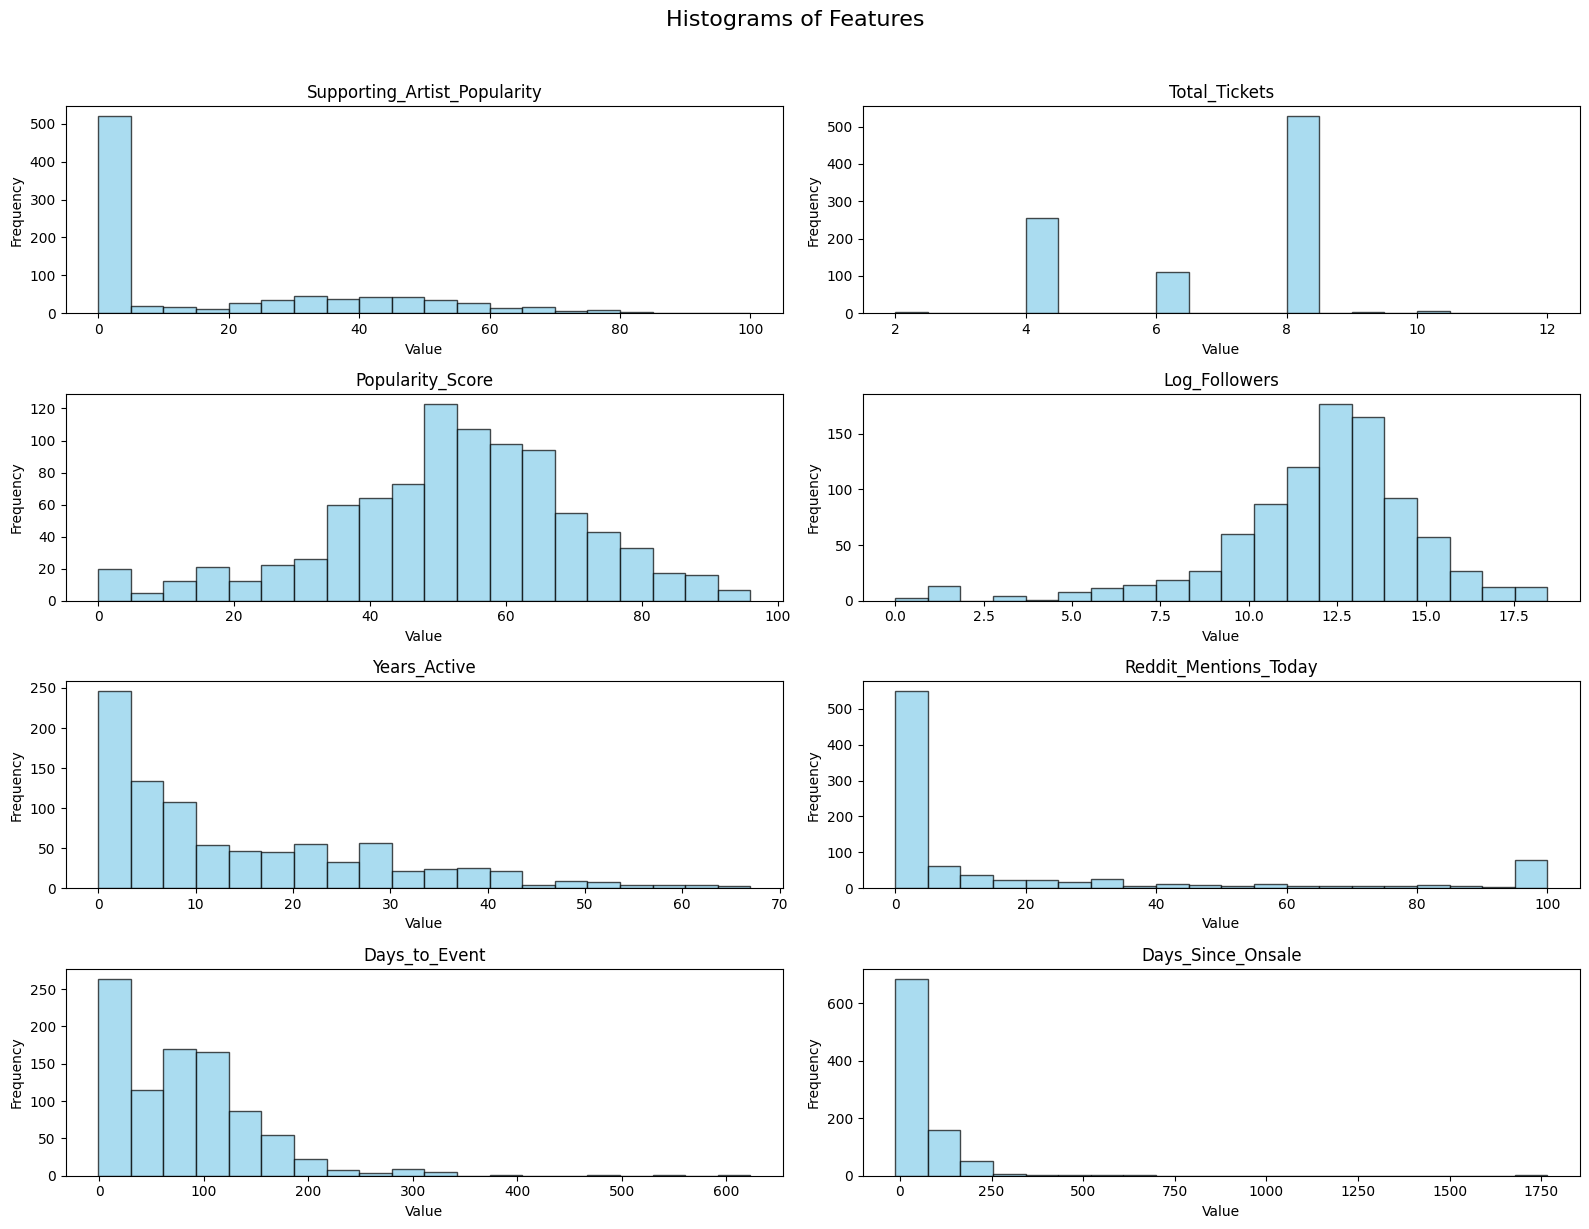

In [6]:
columns_to_plot = ['Supporting_Artist_Popularity', 'Total_Tickets', 'Popularity_Score', 
    'Log_Followers', 'Years_Active', 'Reddit_Mentions_Today', 
    'Days_to_Event', 'Days_Since_Onsale']

# Create histograms
fig, axes = plt.subplots(4, 2, figsize=(16, 12))  
axes = axes.flatten() 

for i, column in enumerate(columns_to_plot):
    axes[i].hist(data[column], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(column, fontsize=12)
    axes[i].set_xlabel('Value', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Remove any unused subplots
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

# Set a common title and adjust layout
fig.suptitle('Histograms of Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**2. Scatter Plot of Dependent Variables**

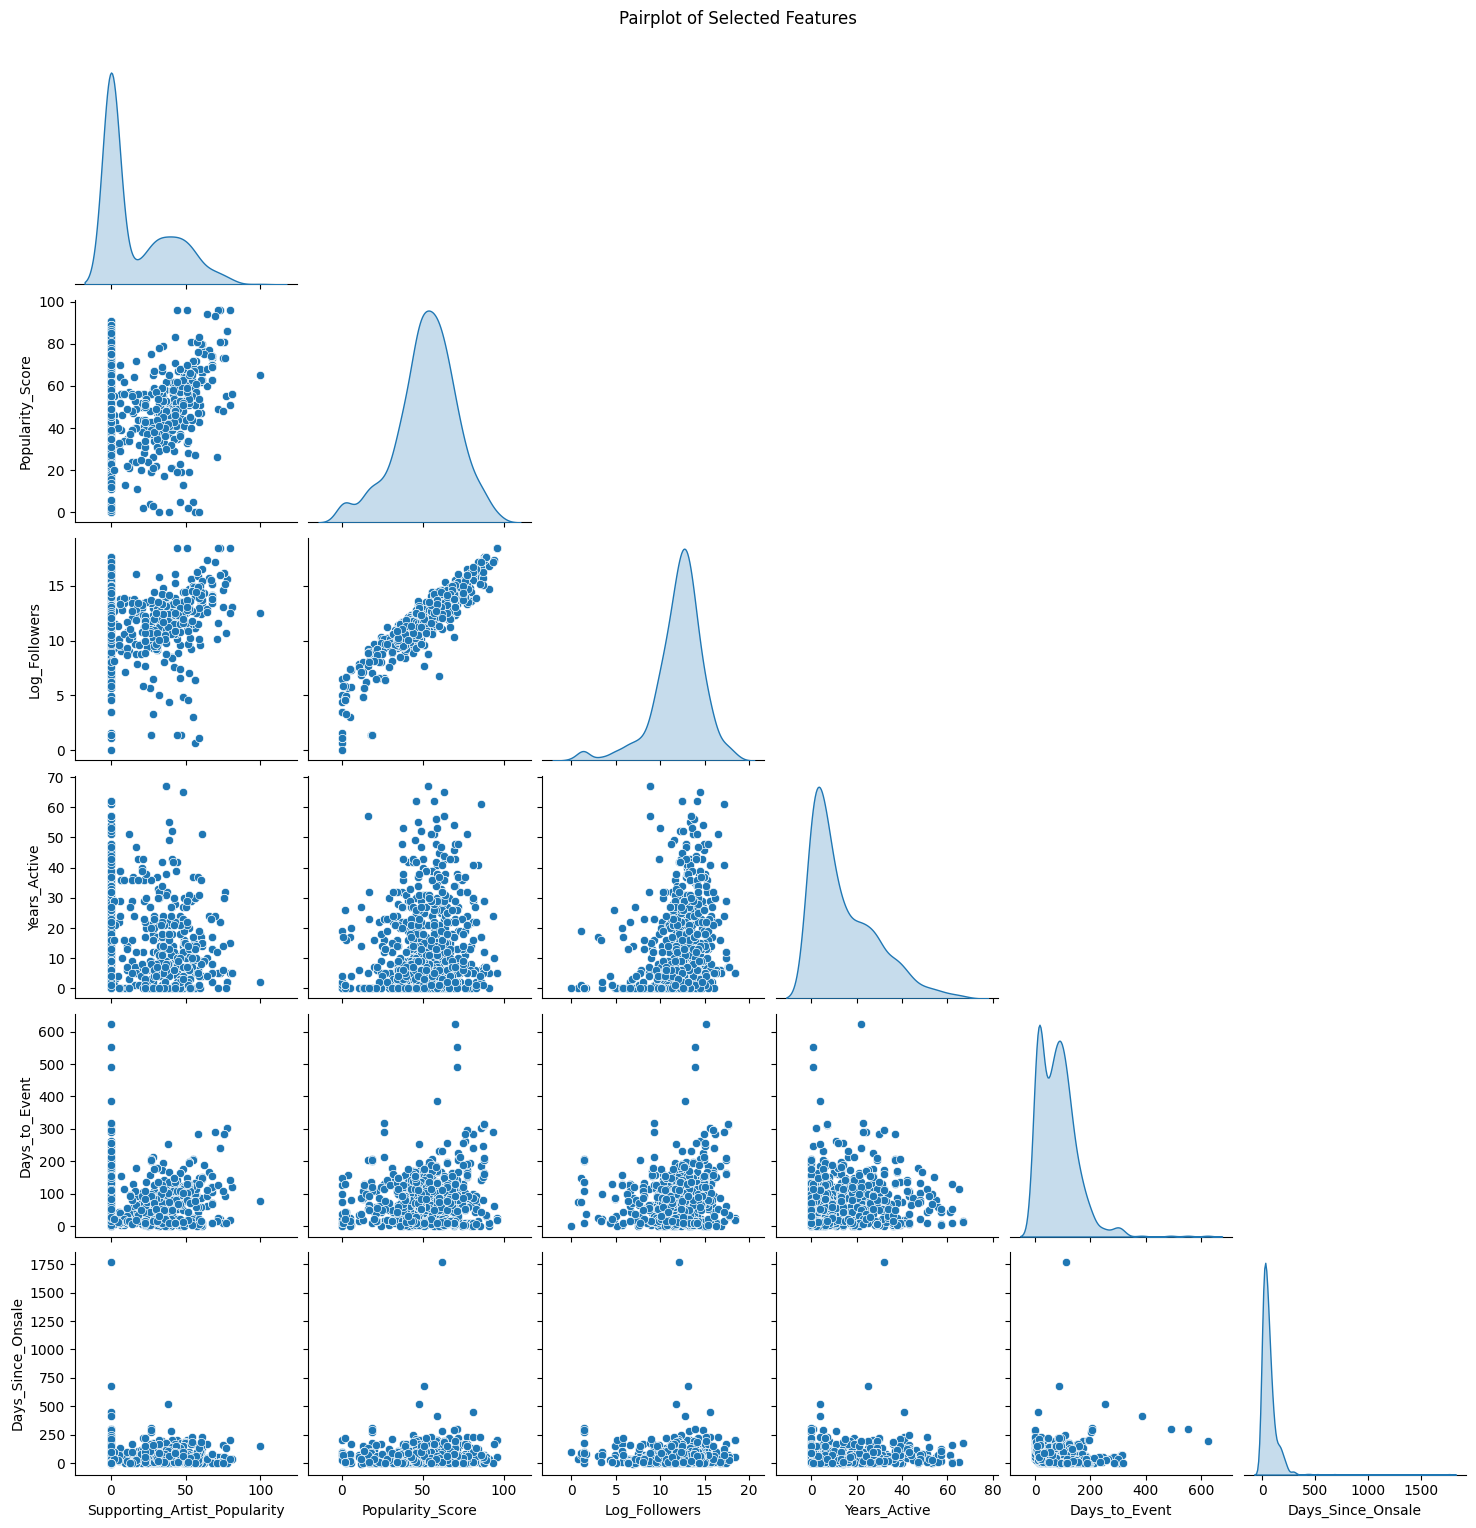

In [7]:
selected_features = ['Supporting_Artist_Popularity', 'Popularity_Score', 
    'Log_Followers', 'Years_Active', 
    'Days_to_Event', 'Days_Since_Onsale']
sns.pairplot(data[selected_features], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

**3. Weekly Distribution of Shows**

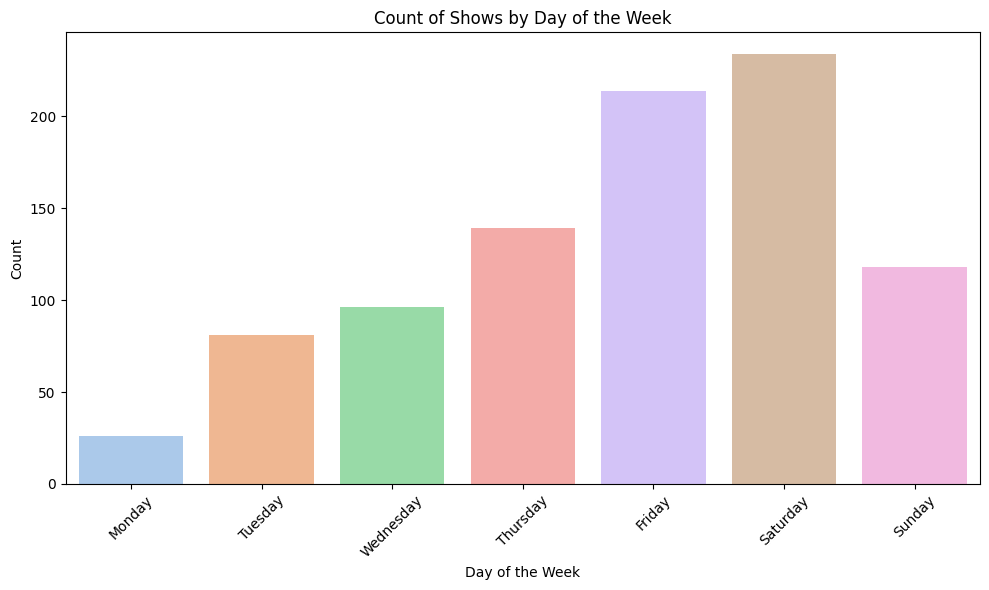

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Day_of_Week', data=data, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='pastel')
plt.title('Count of Shows by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**4. Correlation Plot**

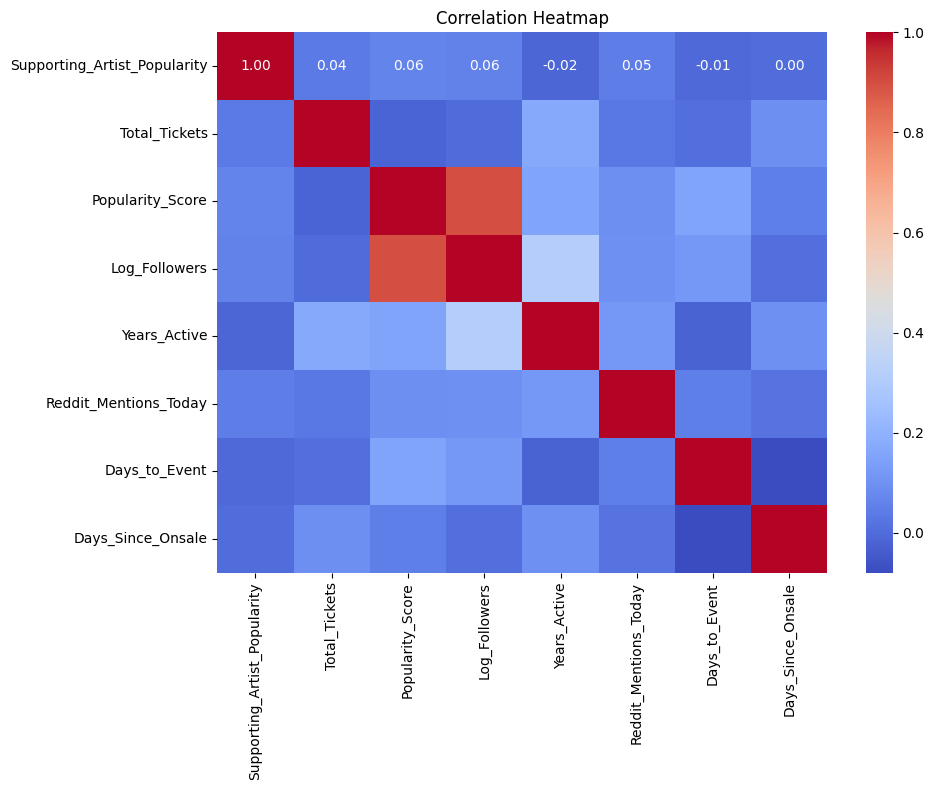

In [9]:
# Compute correlation matrix
correlation_matrix = data[columns_to_plot].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

### VIF test for Multicollinearity

We observe high correlation between `popularity_score` and `Log_followers`. This could be a potential cause of multicollinearity in our model. 

In [10]:
# Define the independent variables (features)
X = data[['Popularity_Score', 'Supporting_Artist_Popularity', 'Years_Active', 
          'Reddit_Mentions_Today',  'Log_Followers', 
          'Days_to_Event', 'Is_Weekend', 'Days_Since_Onsale','Total_Tickets']]

# Add a constant to the model (required for statsmodels VIF calculation)
X_with_const = sm.add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i+1) for i in range(len(X.columns))]

# Display VIF
print("\033[1;34mVariance Inflation Factor (VIF):\033[0m")
print(vif_data)

Variance Inflation Factor (VIF):
                        Feature       VIF
0              Popularity_Score  5.989035
1  Supporting_Artist_Popularity  1.009547
2                  Years_Active  1.305035
3         Reddit_Mentions_Today  1.027653
4                 Log_Followers  6.409897
5                 Days_to_Event  1.040246
6                    Is_Weekend  1.020907
7             Days_Since_Onsale  1.045619
8                 Total_Tickets  1.048608


**We drop `Log_Followers` from the model** due to its high Variance Inflation Factor (VIF), indicating significant multicollinearity with other features, particularly `Popularity_Score`. Multicollinearity can distort model coefficients and reduce interpretability. Since `Popularity_Score` inherently reflects an artist's follower base and captures the impact of their popularity, it effectively serves as a proxy for the same information, making `Log_Followers` redundant in the analysis.

## 3. Model Building

In [11]:
# Define the dependent variable (target)
y = data['Avg_Ticket_Price']

# Define the independent variables (features)
X = data[['Popularity_Score', 'Supporting_Artist_Popularity', 'Years_Active', 
          'Reddit_Mentions_Today', 
          'Days_to_Event', 'Is_Weekend', 'Days_Since_Onsale','Total_Tickets']]

### Baseline OLS Model

In [12]:
# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary table
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:       Avg_Ticket_Price   R-squared (uncentered):                   0.639
Model:                            OLS   Adj. R-squared (uncentered):              0.635
Method:                 Least Squares   F-statistic:                              198.8
Date:                Mon, 02 Dec 2024   Prob (F-statistic):                   4.84e-193
Time:                        00:36:35   Log-Likelihood:                         -4743.0
No. Observations:                 908   AIC:                                      9502.
Df Residuals:                     900   BIC:                                      9541.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

**The regression results show that:**

`Popularity_Score`, `Years_Active`, `Days_to_Event`, and `Is_Weekend` have a ***positive*** impact on average ticket prices, with `Popularity_Score` and `Is_Weekend` being the most influential. 

Conversely, `Total_Tickets` has a ***negative*** impact, indicating higher availability lowers prices. 

`Supporting_Artist_Popularity`, `Reddit_Mentions_Today`, and `Days_Since_Onsale` have minimal or statistically insignificant effects on ticket prices in this model, hence we remove them from further analysis

In [13]:
# Dropping insignificant variables
X_final = X[['Popularity_Score', 'Supporting_Artist_Popularity', 'Years_Active',  
          'Days_to_Event', 'Is_Weekend', 'Days_Since_Onsale']]

### Comparison of Regression Models

1. **Ordinary Least Squares (OLS) Regression**
2. **Ridge Regression** (with hyperparameter tuning using GridSearchCV)
3. **Lasso Regression** (with hyperparameter tuning using GridSearchCV)
4. **ElasticNet Regression**
5. **Decision Tree Regression**
6. **Random Forest Regression**

Mean Squared Error Values for all Models:

OLS: MSE = 1845.1846
Ridge: MSE = 1835.7654
Lasso: MSE = 1844.3379
ElasticNet: MSE = 1809.0164
Decision Tree: MSE = 1280.0329
Random Forest: MSE = 1069.7594


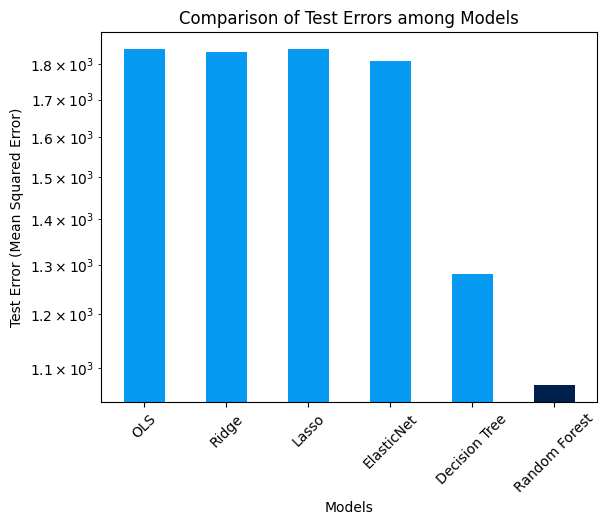

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Standardize the features (necessary for Ridge, Lasso, ElasticNet)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model: Ordinary Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
ols_coefficients = linear_model.coef_
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)

# Model: Ridge Regression with GridSearchCV
ridge_model = Ridge()
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge_model, ridge_params, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train_scaled, y_train)
best_ridge_model = ridge_grid.best_estimator_  
ridge_coefficients = best_ridge_model.coef_
y_pred_ridge = best_ridge_model.predict(X_test_scaled)  # Fix: Add Ridge predictions
mse_ridge = mean_squared_error(y_test, y_pred_ridge)    # Fix: Calculate Ridge MSE

# Model: Lasso Regression with GridSearchCV
lasso_model = Lasso()
lasso_params = {'alpha': [0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(lasso_model, lasso_params, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_grid.best_estimator_.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

# Model: ElasticNet Regression
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_model.fit(X_train_scaled, y_train)
y_pred_elastic_net = elastic_net_model.predict(X_test_scaled)
mse_elastic_net = mean_squared_error(y_test, y_pred_elastic_net)

# Model: Decision Tree Regression
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)

# Model: Random Forest Regression
forest_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)

# Comparison of Models
model_names = ['OLS', 'Ridge', 'Lasso', 'ElasticNet', 'Decision Tree', 'Random Forest']
test_errors = [mse_linear, mse_ridge, mse_lasso, mse_elastic_net, mse_tree, mse_forest]

# Determine the darkest blue for the lowest MSE
low_mse = min(test_errors)
colors = ['#069AF3' if error != low_mse else '#001f4d' for error in test_errors]

# Print MSE Values
print("\033[1;34mMean Squared Error Values for all Models:\033[0m")
print("")
for model, error in zip(model_names, test_errors):
    print(f"{model}: MSE = {error:.4f}")

# Create a bar graph for test errors
plt.bar(model_names, test_errors, color=colors, width=0.5)
plt.xlabel('Models')
plt.ylabel('Test Error (Mean Squared Error)')
plt.title('Comparison of Test Errors among Models')
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()


We select **`Random Forest`** for our prediction model as it offers the lowest MSE score of 1069.75, indicating that it provides the most accurate predictions with the least error among the tested models.

### Model Tuning: Optimizing Random Forest Hyperparameters

In [15]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],  # Test different depths
    'min_samples_split': [2, 5, 10],  # Test minimum splits
    'min_samples_leaf': [1, 2, 4]     # Test minimum samples in leaves
}

# Initialize the RandomForestRegressor with 200 trees
rf = RandomForestRegressor(n_estimators=200, random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  
    scoring='neg_mean_squared_error',  
    n_jobs=-1 
)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_rf = grid_search.best_estimator_

# Print the best parameters
print("\033[1;34m\033[1mBest Parameters for Random Forest with 200 Trees:\033[0m")
for param, value in grid_search.best_params_.items():
    print(f" - {param}: {value}")

Best Parameters for Random Forest with 200 Trees:
 - max_depth: 20
 - min_samples_leaf: 1
 - min_samples_split: 5


### Feature Importance Analysis

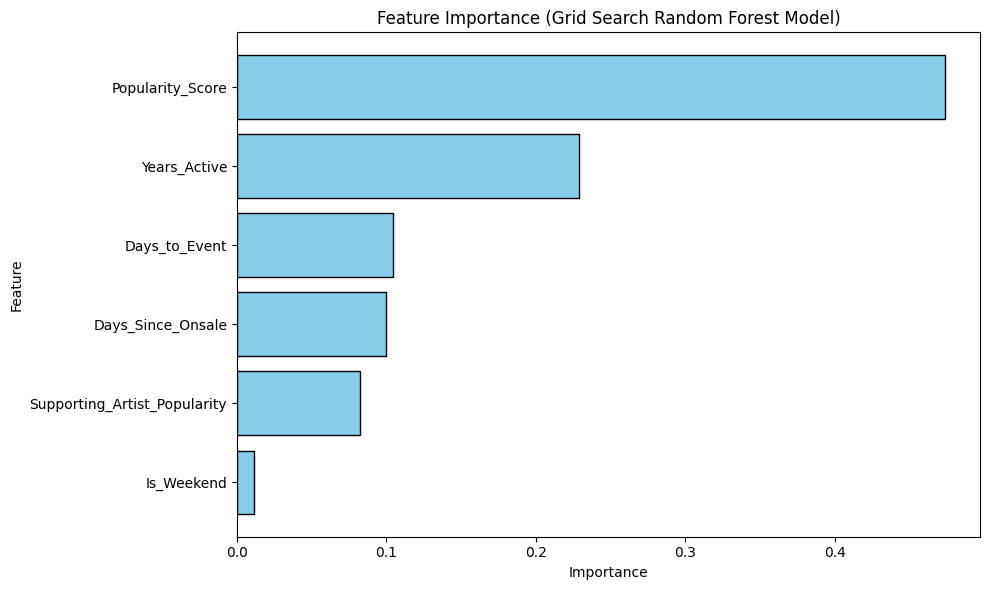

In [16]:
# Extract feature importances from the model
feature_importance = best_rf.feature_importances_

# Ensure feature names are extracted from X
feature_names = X_final.columns  

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue', edgecolor='black')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Grid Search Random Forest Model)')
plt.gca().invert_yaxis()  # Flip to show highest importance at the top
plt.tight_layout()
plt.show()

In [17]:
print("\033[1;34mFeature Importances:\033[0m")
print(feature_importance_df.to_string(index=False))

Feature Importances:
                     Feature  Importance
            Popularity_Score    0.473337
                Years_Active    0.228565
               Days_to_Event    0.104656
           Days_Since_Onsale    0.099618
Supporting_Artist_Popularity    0.082101
                  Is_Weekend    0.011724


### Tuning for Optimal Number of Features

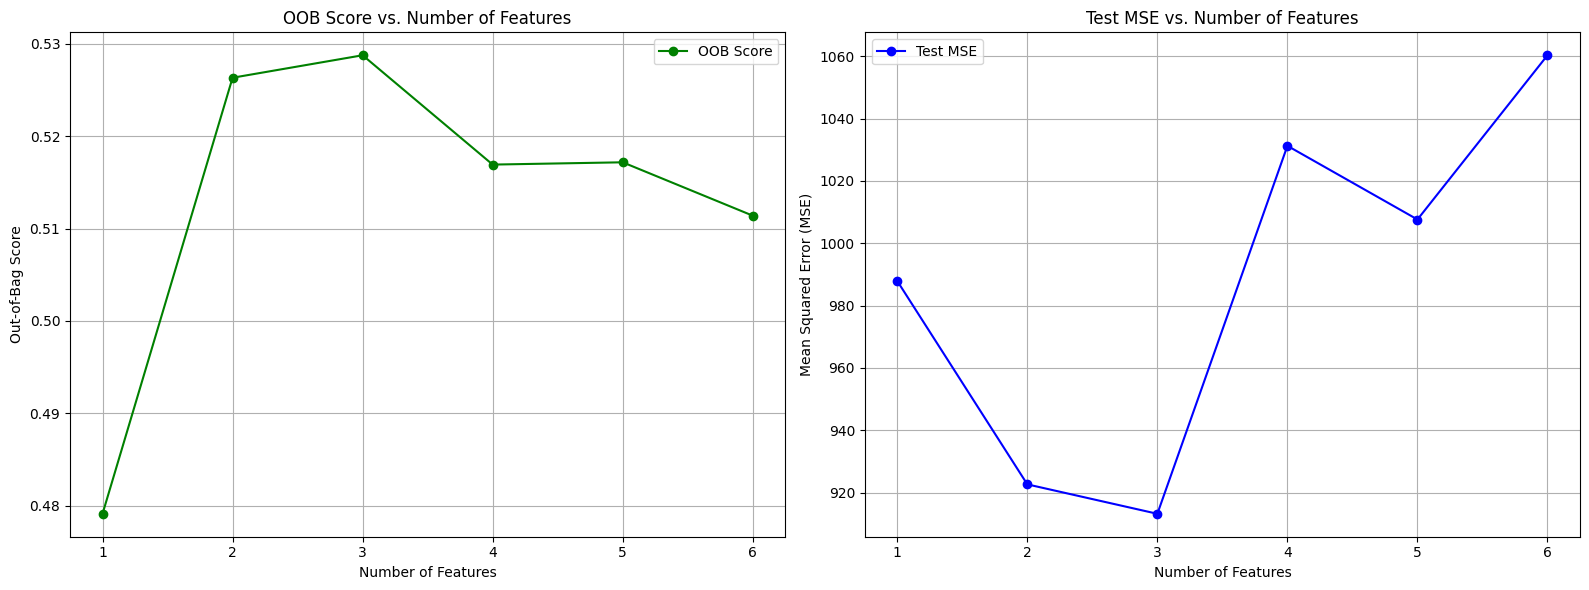

In [18]:
# Define the range of features to tune
Features = range(1, X_train.shape[1] + 1)  
oob_scores = []
test_mse_scores = []

# Tune for the ideal number of features
for max_features in Features:
    # Initialize the RandomForestRegressor with best parameters and varying max_features
    rf = RandomForestRegressor(
        n_estimators=200,  # From grid search
        max_features=max_features,  # Varying max_features
        max_depth=best_rf.max_depth,  # From grid search
        min_samples_split=best_rf.min_samples_split,  # From grid search
        min_samples_leaf=best_rf.min_samples_leaf,  # From grid search
        oob_score=True,  
        random_state=42
    )
    
    # Fit the model on training data
    rf.fit(X_train, y_train)
    
    # Store OOB score
    oob_scores.append(rf.oob_score_)
    
    # Predict on the test set and calculate MSE
    y_pred = rf.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred)
    test_mse_scores.append(mse_test)

# Create a DataFrame to store the results
feature_tuning_results = pd.DataFrame({
    'Number of Features': Features,
    'OOB Score': oob_scores,
    'Test MSE': test_mse_scores
})

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot OOB Score vs. Number of Features
axes[0].plot(feature_tuning_results['Number of Features'], feature_tuning_results['OOB Score'], 
             marker='o', label='OOB Score', color='green')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Out-of-Bag Score')
axes[0].set_title('OOB Score vs. Number of Features')
axes[0].grid(True)
axes[0].legend()

# Plot Test MSE vs. Number of Features
axes[1].plot(feature_tuning_results['Number of Features'], feature_tuning_results['Test MSE'], 
             marker='o', label='Test MSE', color='blue')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Mean Squared Error (MSE)')
axes[1].set_title('Test MSE vs. Number of Features')
axes[1].grid(True)
axes[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

We select **3 features** as the optimal number because it strikes the ideal balance by maximizing the Out-of-Bag (OOB) score while minimizing the Test Mean Squared Error (MSE). This combination ensures both high model accuracy and low prediction error, aligning with the goals of our model tuning process.

### Training Random Forest with Optimized Parameters

In [19]:
final_rf_model = RandomForestRegressor(
    n_estimators=200,         
    max_features=3,           
    max_depth=20,            
    min_samples_split=2,      
    min_samples_leaf=1,       
    random_state=42,          
    oob_score=True            
)

# Fit the final model on the training data
final_rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_final = final_rf_model.predict(X_test)

## 4. Model Evaluation

In [20]:
# Calculate evaluation metrics
final_mse = mean_squared_error(y_test, y_pred_final)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)

# Print the final model evaluation metrics
print("\033[1;34mFinal Model Evaluation Metrics:\033[0m")
print(f"Test MSE: {final_mse:.4f}")
print(f"Test RMSE: {final_rmse:.4f}")
print(f"Test MAE: {final_mae:.4f}")
print(f"Test R² Score: {final_r2:.4f}")
print(f"OOB Score: {final_rf_model.oob_score_:.4f}")

Final Model Evaluation Metrics:
Test MSE: 870.6763
Test RMSE: 29.5072
Test MAE: 19.0723
Test R² Score: 0.5021
OOB Score: 0.5333


In [21]:
avg_ticket_price_range = data['Avg_Ticket_Price'].min(), data['Avg_Ticket_Price'].max()
print("\033[1;34mRange of Average Ticket Prices:\033[0m")
print(avg_ticket_price_range)

Range of Average Ticket Prices:
(10.0, 477.5)


### Interpretation

The evaluation metrics for the Random Forest model indicate its performance relative to the range of average ticket prices in the training data, which spans from $10.0 to $477.5. 

The **Test MSE** of 870.68 and **Test RMSE** of 29.51 suggest that, on average, the model's predictions deviate by approximately $29.51 from the actual values. This error is reasonable given the wide price range. 

The **Test MAE** of 19.07 further indicates that the model's average absolute error is around $19, showing consistency in predictions. 

The **R² Score** of 0.5021 highlights that the model explains about 50.21% of the variance in ticket prices, which is satisfactory for this type of data. 

Lastly, the **OOB Score** of 0.5333 supports the model's generalizability to unseen data.

### Diagnostic Plots

**1. Residual Plot**

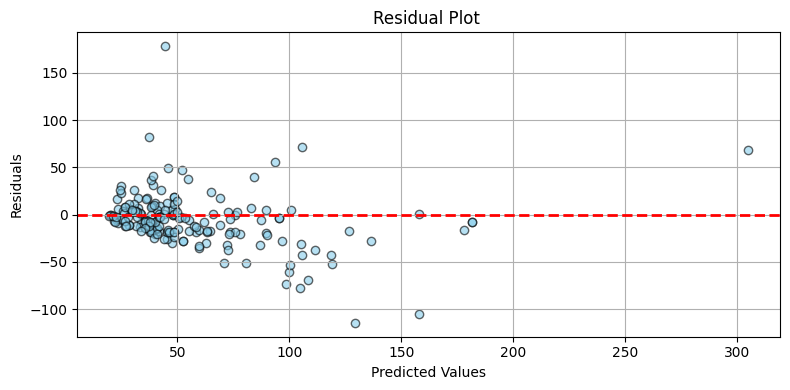

In [22]:
# Calculate residuals
residuals = y_test - y_pred_final

# Plot residuals
plt.figure(figsize=(8, 4))
plt.scatter(y_pred_final, residuals, alpha=0.6, edgecolor='black', color='skyblue')
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Reference line at 0
plt.title('Residual Plot ')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

The residual plot shows the difference between the actual and predicted values (residuals) against the predicted values. Ideally, the residuals should be randomly scattered around the horizontal line at zero - **homoscedastic**, indicating no clear pattern and that the model captures the underlying data structure effectively. 

In this plot:
1. Most residuals are centered around zero, indicating the model generally performs well.
2. Some outliers and non-uniform spread suggest slight heteroscedasticity (variance of residuals changes with predicted values), which could indicate areas for model improvement.

**Breusch-Pagan Test for Heterscedasticity**

In [23]:
# Assuming y_test and y_pred_final are defined
residuals = y_test - y_pred_final  # Calculate residuals
X_with_const = add_constant(X_test)  # Add a constant term to the independent variables

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_with_const)

# Output the test results
print("\033[1;34m\033[1mBreusch-Pagan Test Results:\033[0m")
print(f"LM Statistic: {bp_test[0]:.4f}, p-value: {bp_test[1]:.4f}")
print(f"F-Statistic: {bp_test[2]:.4f}, F p-value: {bp_test[3]:.4f}")

Breusch-Pagan Test Results:
LM Statistic: 8.1169, p-value: 0.2297
F-Statistic: 1.3615, F p-value: 0.2327


Since both p-values (0.2297 and 0.2327) are greater than 0.05, we do not have evidence of heteroscedasticity. This is a **desired result** because it means the residuals have **constant variance - homoscedasticity**. 

Homoscedasticity means that the spread of residuals (errors) is consistent across all levels of predicted values. In other words, the variance of errors does not increase or decrease systematically as the predicted values change. This ensures the model's predictions are reliable and that the relationship between the independent and dependent variables is stable across the dataset.


**2. Q-Q Plot**

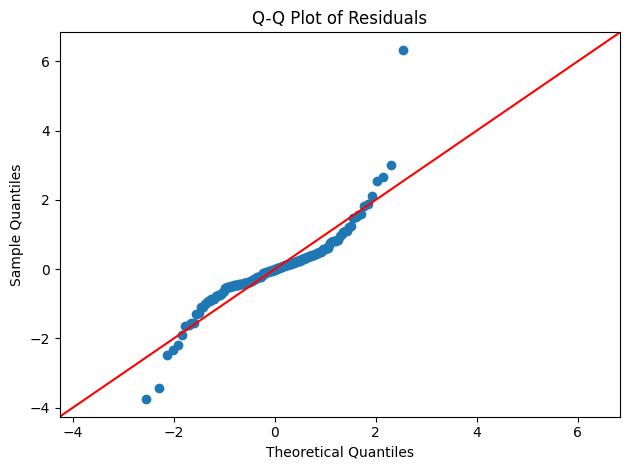

In [24]:
# Generate Q-Q plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

The Q-Q plot compares the quantiles of the residuals to a standard normal distribution to assess their normality. 

In this plot:

1. The residuals mostly align with the red diagonal line, especially near the center, indicating that the residuals approximately follow a normal distribution in this range.
2. At the tails (extreme values), some deviation from the line is observed, suggesting potential outliers or slight non-normality in the extreme residuals.

This is a generally **desired result** because it indicates that the residuals are mostly normally distributed, which satisfies one of the key assumptions for linear regression models.

**3. Scatter Plot for Actual vs. Predicted Values**

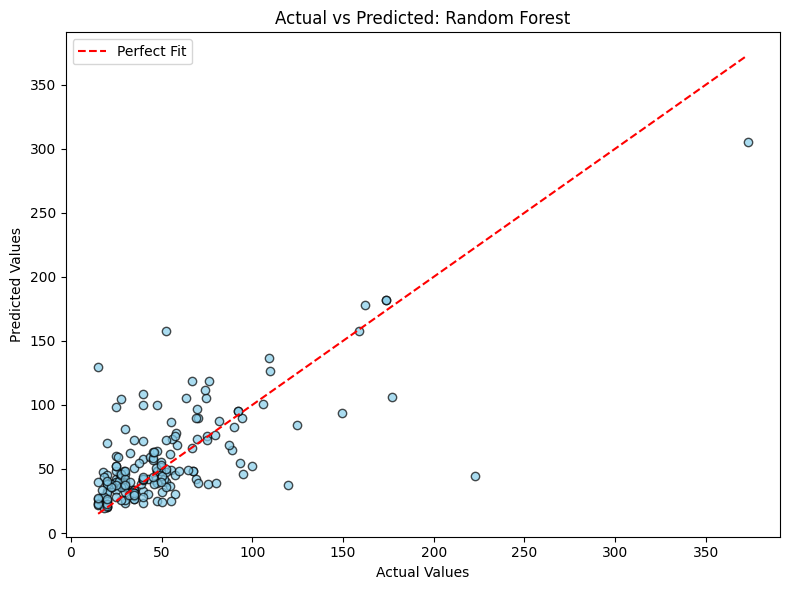

In [25]:
# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_final, alpha=0.7, edgecolor='k', color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted: Random Forest')
plt.legend()
plt.tight_layout()
plt.show()

**4. Cross Validation**

In [26]:
cv_scores = cross_val_score(final_rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print("\033[1;34m\033[1mCross-Validation RMSE Scores:\033[0m", cv_rmse)
print("\033[1;34m\033[1mMean CV RMSE:\033[0m", f"{cv_rmse.mean():.4f}")
print("\033[1;34m\033[1mStandard Deviation CV RMSE:\033[0m", f"{cv_rmse.std():.4f}")

Cross-Validation RMSE Scores: [34.38520468 30.61446803 47.09213087 34.27394023 29.53851191]
Mean CV RMSE: 35.1809
Standard Deviation CV RMSE: 6.2613


The cross-validation results show an average RMSE of 35.18 with a standard deviation of 6.26, indicating moderate variability in model performance across folds. The RMSE ranges from 30.61 to 47.09, suggesting the model's predictions are generally consistent but may vary depending on the data split.

## 5. Predictions

In [27]:
# Define the range for each input variable
input_ranges = {
    "Popularity Score": (0, 100),
    "Supporting Artist Popularity": (0.0, 100.0),
    "Years Active": (0.0, 70.0),
    "Days to Event": (0, 700),
    "Is Weekend (0=No, 1=Yes)": (0, 1),
    "Days Since Onsale": (0.0, 200.0)
}

# Generate random values within the defined ranges
input_data = [
    random.uniform(*input_ranges["Popularity Score"]),
    random.uniform(*input_ranges["Supporting Artist Popularity"]),
    random.uniform(*input_ranges["Years Active"]),
    random.randint(*input_ranges["Days to Event"]),
    random.choice([0, 1]),  # Is Weekend
    random.uniform(*input_ranges["Days Since Onsale"])
]

# Print the generated input values
print("\nGenerated Input Values:")
for key, value in zip(input_ranges.keys(), input_data):
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

# Make a prediction
prediction = final_rf_model.predict([input_data])

# Print the predicted average ticket price
print("\n\033[1;34mPredicted Average Ticket Price:\033[0m ${:.2f}".format(prediction[0]))



Generated Input Values:
Popularity Score: 91.67
Supporting Artist Popularity: 24.53
Years Active: 49.26
Days to Event: 151
Is Weekend (0=No, 1=Yes): 1
Days Since Onsale: 178.47

Predicted Average Ticket Price: $193.71


In [28]:
slider_layout = Layout(width='40%')  
description_style = {'description_width': 'initial'}  

popularity_score = widgets.IntSlider(description='Popularity Score:', min=0, max=100, step=1, value=50, layout=slider_layout, style=description_style)
supporting_artist_popularity = widgets.FloatSlider(description='Supporting Artist Popularity:', min=0.0, max=100.0, step=1.0, value=20.0, layout=slider_layout, style=description_style)
years_active = widgets.FloatSlider(description='Years Active (in years):', min=0.0, max=70.0, step=1.0, value=14.0, layout=slider_layout, style=description_style)
days_to_event = widgets.IntSlider(description='Days to Event (remaining):', min=0, max=700, step=10, value=100, layout=slider_layout, style=description_style)
is_weekend = widgets.ToggleButtons(options=[('No', 0), ('Yes', 1)], value=0, description='Is Weekend:', style=description_style)
days_since_onsale = widgets.FloatSlider(description='Days Since Onsale (in days):', min=0.0, max=200.0, step=1.0, value=60.0, layout=slider_layout, style=description_style)

output = widgets.Output()

def on_predict_button_clicked(b):
 with output:
  output.clear_output()
  input_data = [
   popularity_score.value,
   supporting_artist_popularity.value,
   years_active.value,
   days_to_event.value,
   is_weekend.value,
   days_since_onsale.value
  ]
  prediction = final_rf_model.predict([input_data])
  print("\n\033[1;34mPredicted Average Ticket Price:\033[0m ${:.2f}".format(prediction[0]))

predict_button = widgets.Button(description='Predict', button_style='success')
predict_button.on_click(on_predict_button_clicked)

display(widgets.VBox([
 widgets.HTML("<h3 style='color:blue; font-weight:bold;'>Dynamic Ticket Price Calculator</h3>"),
 popularity_score, 
 supporting_artist_popularity, 
 years_active, 
 days_to_event, 
days_since_onsale, 
 is_weekend, 
 predict_button, 
 output
]))